<a href="https://colab.research.google.com/github/bmurmann/Ngspice-on-Colab/blob/main/notebooks/SKY130_Track_and_Hold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKY130 Track and Hold Circuit

# Tool setup

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()

# install sky130a
!conda install -c litex-hub open_pdks.sky130a

# install ngspice
!conda install -c litex-hub ngspice

✨🍰✨ Everything looks OK!
Channels:
 - litex-hub
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Channels:
 - litex-hub
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



# Simulation

In [12]:
%%writefile .spiceinit
* ngspice initialization for sky130
* assert BSIM compatibility mode with "nf" vs. "W"
set ngbehavior=hsa
* "nomodcheck" speeds up loading time
set ng_nomodcheck

Overwriting .spiceinit


In [206]:
%%writefile netlist.spice
* Track-and-hold circuit using single NMOS
.lib "/usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice" tt
x1 in clk out 0 sky130_fd_pr__nfet_01v8_lvt w=5 l=0.15
cl out 0 100f
vin  in 0 sin (0.4 0.2 {fin})
vclk clk 0 pulse (1.2 0 0 100p 100p {per/2} {per})
.param nfft=64 fclk=10Meg per=1/fclk cycles=3 fin=fclk*cycles/nfft

Overwriting netlist.spice


In [207]:
%%writefile sim1.spice
* First simulation "continuous time"
.inc netlist.spice
.option method=gear
.tran 1n {per*(nfft+3)}
.control
set wr_singlescale
set wr_vecnames
run
wrdata output1.txt out
.endc

Overwriting sim1.spice


In [208]:
%%writefile sim2.spice
* Second simulation "discrete time"
.inc netlist.spice
.option method=gear reltol=1e-6 interp
.tran {per} {per*(nfft+3)} {0.25*per}
.control
set wr_singlescale
set wr_vecnames
run
wrdata output2.txt out
.endc

Overwriting sim2.spice


In [209]:
!ngspice -b sim1.spice


Note: Compatibility modes selected: hs a



Circuit: * first simulation "continuous time"

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
in                                         0.4
clk                                        1.2
out                                        0.4
vclk#branch                                  0
vin#branch                            -8.2e-13

 Reference value :  0.00000e+00
No. of Data Rows : 8203
Note: Simulation executed from .control section 


In [210]:
!ngspice -b sim2.spice


Note: Compatibility modes selected: hs a



Circuit: * second simulation "discrete time"

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000



Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
in                                         0.4
clk                                        1.2
out                                        0.4
vclk#branch                                  0
vin#branch                            -8.2e-13

 Reference value :  3.59813e-08
No. of Data Rows : 67
Note: Simulation executed from .control section 


In [165]:
df1 = pd.read_csv("output1.txt", delim_whitespace=True)
df1

,time,out
0,0.000000e+00,0.400000
1,1.000000e-12,0.399961
2,2.000000e-12,0.399922
3,4.000000e-12,0.399845
4,8.000000e-12,0.399695
...,...,...
8171,6.696980e-06,0.550194
8172,6.697980e-06,0.550560
8173,6.698980e-06,0.550924
8174,6.699980e-06,0.551286


In [166]:
df2 = pd.read_csv("output2.txt", delim_whitespace=True)
df2

,time,out
0,1.250000e-07,0.454973
1,2.250000e-07,0.507224
2,3.250000e-07,0.549400
3,4.250000e-07,0.578512
4,5.250000e-07,0.593953
...,...,...
62,6.325000e-06,0.339253
63,6.425000e-06,0.397230
64,6.525000e-06,0.454973
65,6.625000e-06,0.507224


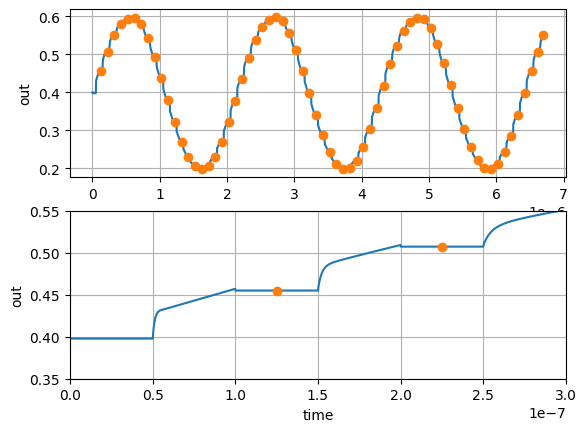

In [211]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df1['time'], df1['out'])
ax1.plot(df2['time'], df2['out'], "o")
ax1.grid()
ax1.set_ylabel("out")

ax2.plot(df1['time'], df1['out'])
ax2.plot(df2['time'], df2['out'], "o")
ax2.grid()
ax2.set_xlabel("time")
ax2.set_ylabel("out")
ax2.set_xlim([0, 0.3e-6])
ax2.set_ylim([0.35, 0.55]);

In [212]:
# Check periodicity/staedy state by comparing the last sample of the FFT window with one right before the window
nfft=64
y = df2['out'].values
# Remove last point since it's off the sampling grid
y = y[:-1]
print(len(y))
relative_error = (y[-1]-y[-1-nfft])/y[-1]
print(relative_error)
y = y[-nfft:]
print(len(y))

66
4.3570497368749493e-07
64


In [225]:
spec = np.fft.rfft(y)
spec_dbv = 20*np.log10(np.abs(spec)/(nfft/2))
print(spec_dbv)

[  -1.98914635 -121.66389067 -121.12925715  -13.97012491 -120.70952902
 -123.16559413  -55.51547487 -118.27270989 -125.81908835  -57.4794055
 -117.58711299 -128.10352442  -61.15749505 -115.37213457 -130.31438188
  -65.86423984 -114.88764251 -132.41231172  -70.96001863 -114.61187899
 -130.07699801  -76.00573501 -107.36561056 -133.02836437  -81.14023237
 -101.69713416 -132.95440738  -86.70428333  -98.07097427 -141.31116052
  -92.11725733  -95.58269458 -141.71049235]


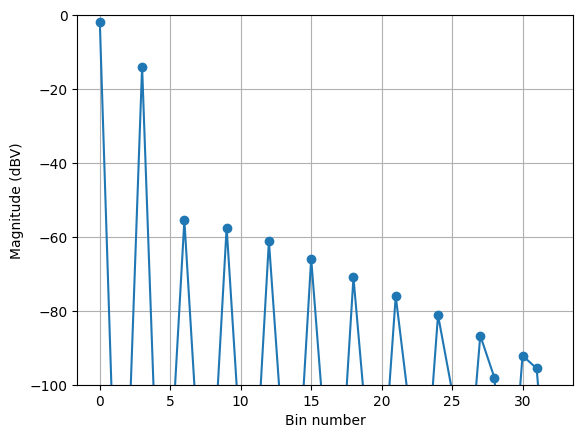

In [226]:
plt.plot(spec_dbv, "-o")
plt.grid()
plt.xlabel("Bin number")
plt.ylabel("Magnitude (dBV)");
plt.ylim([-100, 0]);

In [229]:
hd3_db = spec_dbv[3]-spec_dbv[6]
print(hd3_db)

41.5453499593735
